# Training

In [1]:
import re

#library to read and import file from drive
import os

import cv2 as cv

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

#### Functions

In [2]:
# Load train images (all without defects)
def train_loader(dir='./', scale=False):
    imgs = []
    for img in os.listdir(dir):
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        imgs.append(image)
    return imgs

In [3]:
# Load the validation set (all with defects)
def test_loader(dir='./', scale=False):
    imgs = {}
    for img in os.listdir(dir):
        img_num = int(re.findall(r'NOK_(\d+)-', img)[0])
        img_order = int(re.findall(r'NOK_\d+-(\d+)', img)[0])
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        if img_num in imgs.keys():
            imgs[img_num].append([img_order, image])
        else:
            imgs[img_num] = [[img_order, image]]
    return imgs

In [20]:
def plot_hist(hist, title):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Data loader

In [4]:
X_train = train_loader('../Data/Prepared/Train/OK', scale=True)
X_noisy = train_loader('../Data/Prepared/Train/noisyOK', scale=True)
X_anomaly = test_loader('../Data/Prepared/Train/NOK', scale=True)

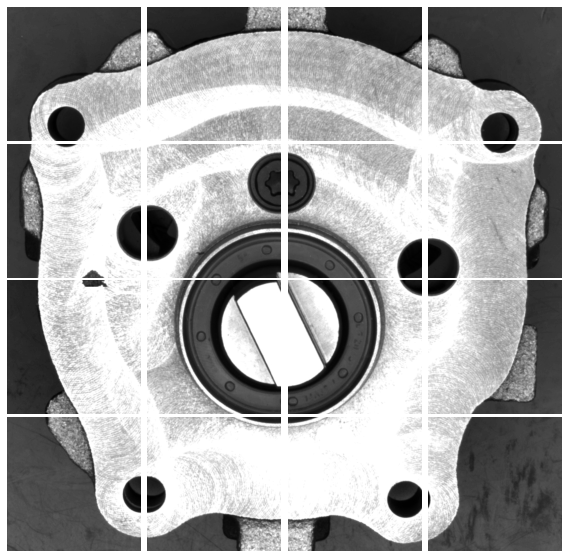

In [5]:
plt.figure(figsize=(10, 10))
for part in X_anomaly[1]:
    plt.subplot(4, 4, (part[0]+1))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.imshow(part[1], cmap='gray')

## Train e validation set

In [6]:
X_train, X__train_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)
X_noisy, X__noisy_val = train_test_split(np.expand_dims(np.array(X_noisy), -1), test_size=0.2, random_state=17)

# Autoencoder

### Diverse architeture di autoencoder

Autoencoder con fully connected

In [58]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

img_shape = X_train.shape[1:]
input_img = Input(img_shape)

#encoded = Dense(1, activation='relu')
encoded = Flatten()(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)

decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(np.prod(img_shape))(decoded)
decoded = Reshape((img_shape))(decoded)

In [59]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adamax', loss='mse')

In [60]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 flatten_10 (Flatten)        (None, 65536)             0         
                                                                 
 dense_50 (Dense)            (None, 256)               16777472  
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dense_52 (Dense)            (None, 256)               33024     
                                                                 
 dense_53 (Dense)            (None, 65536)             16842752  
                                                                 
 reshape_9 (Reshape)         (None, 256, 256, 1)       0   

In [68]:
#add early stopping
custom_early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min')

#random seed 
tf.keras.utils.set_random_seed(7)

hist=autoencoder.fit(X_noisy, X_train, epochs=300, batch_size=16, shuffle=True,
                     validation_data=(X__noisy_val, X__train_val), callbacks=[custom_early_stopping])

Epoch 1/300
67/67 [==============================] - 20s 295ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 2/300
67/67 [==============================] - 20s 292ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/300
67/67 [==============================] - 20s 293ms/step - loss: 9.5193e-04 - val_loss: 0.0014
Epoch 4/300
67/67 [==============================] - 20s 291ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/300
67/67 [==============================] - 19s 291ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/300
67/67 [==============================] - 20s 294ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 7/300
67/67 [==============================] - 20s 293ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/300
67/67 [==============================] - 20s 293ms/step - loss: 6.9248e-04 - val_loss: 8.8185e-04
Epoch 9/300
67/67 [==============================] - 20s 293ms/step - loss: 6.7700e-04 - val_loss: 0.0014
Epoch 10/300
67/67 [==============================] - 20s 293ms/st

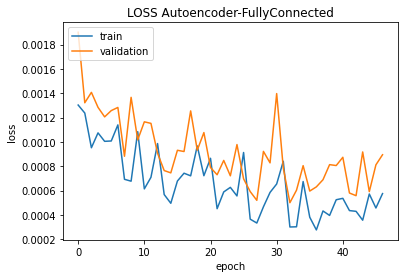

In [69]:
plot_hist(hist, 'Autoencoder-FullyConnected')

### Sample with spot artificially producted

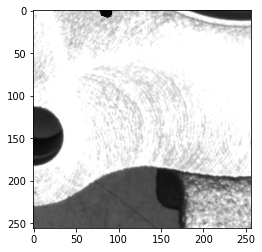

In [70]:
plt.imshow(np.squeeze(X_noisy[5],-1), cmap='gray')

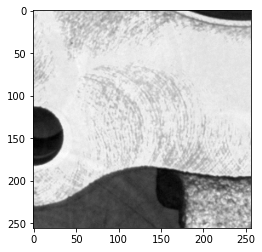

In [71]:
test_artificial = autoencoder.predict(np.expand_dims(X_noisy[5],0))
plt.imshow(np.squeeze(test_artificial[0], -1), cmap='gray')

### Sample with real spot

In [78]:
sample = cv.imread("../Data/Prepared/Test/NOK/NOK_0-13.jpg", cv.IMREAD_GRAYSCALE)

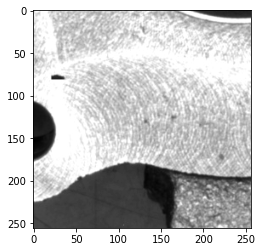

In [79]:
plt.imshow(sample, cmap='gray')

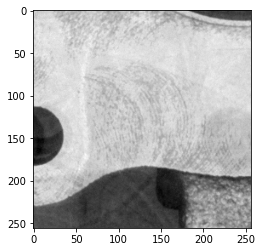

In [80]:
test_real = autoencoder.predict(np.expand_dims(sample,0))
plt.imshow(np.squeeze(test_real[0], -1), cmap='gray')

### Saving model 

In [81]:
autoencoder.save("../Models/autoencoderFC")

INFO:tensorflow:Assets written to: ../Models/autoencoderFC/assets
